<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [444]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
from itertools import combinations

# Otros objetivos
# -----------------------------------------------------------------------
import sys
import os

# Ruta relativa desde notebooks/1-Preprocesing/ a src/
src_path = "src/"
sys.path.append(src_path)

import support_preprocesing as sp  # Importa la función desde el archivo

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor

In [445]:
df=pd.read_csv("data/financial_data.csv")

In [446]:
df.sample(5)

transaction_id  customer_id  merchant_id   amount     transaction_time  \
523              524         1026         2079  5875.38  2023-01-01 00:08:43   
3326            3327         1028         2064  6596.05  2023-01-01 00:55:26   
538              539         1045         2020  3804.71  2023-01-01 00:08:58   
3176            3177         1039         2100  2306.21  2023-01-01 00:52:56   
5917            5918         1096         2076  1377.90  2023-01-01 01:38:37   

      is_fraudulent         card_type location purchase_category  \
523               0  American Express  City-38       Gas Station   
3326              0        MasterCard  City-24        Restaurant   
538               1  American Express  City-26            Retail   
3176              1  American Express  City-23         Groceries   
5917              1        MasterCard  City-39       Gas Station   

      customer_age    transaction_description  
523             70  Purchase at Merchant-2079  
3326            47  Purchase at Merchant-2064  
538             22  Purchase at Merchant-2020  
3176            20  Purchase at Merchant-2100  
5917            70  Purchase at Merchant-2076

In [447]:
categorical_columns = ["transaction_id", "customer_id", "merchant_id"]
df[categorical_columns] = df[categorical_columns].astype(object)

In [448]:
# Convert 'transaction_time' to datetime for proper time calculations
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

In [449]:
import pandas as pd

# Crear frecuencia de transacciones por cliente
df['transaction_count_per_customer'] = df.groupby('customer_id')['transaction_id'].transform('count')

# Calcular el monto total de transacciones por cliente
df['total_amount_per_customer'] = df.groupby('customer_id')['amount'].transform('sum')

# Calcular el promedio del monto de transacciones por cliente
df['average_transaction_amount'] = df.groupby('customer_id')['amount'].transform('mean')

# Calcular la diferencia de tiempo entre transacciones consecutivas
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df['time_difference'] = df.groupby('customer_id')['transaction_time'].diff().dt.total_seconds()

# Categorizar 'amount' en cuartiles
df['age_category'] = pd.qcut(df['customer_age'], 
                                             q=4, 
                                             labels=['Joven', 'Joven-adulto', 'Adulto', 'Senior']).astype(object)

# Calcular proporción de fraude por cliente y en tienda
df['fraud_rate_per_customer'] = df.groupby('customer_id')['is_fraudulent'].transform('mean')
df['fraud_rate_per_merchant'] = df.groupby('merchant_id')['is_fraudulent'].transform('mean')

# Calcular número de transacciones por ubicación
df['transaction_count_per_location'] = df.groupby('location')['transaction_id'].transform('count')

# Categorizar 'amount' en cuartiles
df['transaction_amount_category'] = pd.qcut(df['amount'], 
                                             q=4, 
                                             labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']).astype(object)


# Calcular el número de comerciantes únicos asociados a cada cliente
df['merchant_per_customer'] = df.groupby('customer_id')['merchant_id'].transform('nunique')

# El DataFrame `df` ahora contiene todas las columnas nuevas
df

transaction_id customer_id merchant_id   amount    transaction_time  \
0                 1        1082        2027  5758.59 2023-01-01 00:00:00   
1                 2        1015        2053  1901.56 2023-01-01 00:00:01   
2                 3        1004        2035  1248.86 2023-01-01 00:00:02   
3                 4        1095        2037  7619.05 2023-01-01 00:00:03   
4                 5        1036        2083  1890.10 2023-01-01 00:00:04   
...             ...         ...         ...      ...                 ...   
9995           9996        1056        2023  8935.28 2023-01-01 02:46:35   
9996           9997        1053        2026    30.15 2023-01-01 02:46:36   
9997           9998        1041        2034  6333.64 2023-01-01 02:46:37   
9998           9999        1009        2019  2837.13 2023-01-01 02:46:38   
9999          10000        1082        2070  7209.43 2023-01-01 02:46:39   

      is_fraudulent         card_type location purchase_category  \
0                 0        MasterCard  City-30       Gas Station   
1                 1              Visa  City-47   Online Shopping   
2                 1        MasterCard   City-6       Gas Station   
3                 1          Discover   City-6            Travel   
4                 1        MasterCard  City-34            Retail   
...             ...               ...      ...               ...   
9995              1        MasterCard  City-39        Restaurant   
9996              0        MasterCard  City-32            Retail   
9997              0  American Express   City-1   Online Shopping   
9998              1              Visa  City-11            Retail   
9999              1          Discover   City-1       Gas Station   

      customer_age    transaction_description  transaction_count_per_customer  \
0               43  Purchase at Merchant-2027                             111   
1               61  Purchase at Merchant-2053                             103   
2               57  Purchase at Merchant-2035                              87   
3               59  Purchase at Merchant-2037                             103   
4               36  Purchase at Merchant-2083                             100   
...            ...                        ...                             ...   
9995            36  Purchase at Merchant-2023                              88   
9996            42  Purchase at Merchant-2026                             101   
9997            36  Purchase at Merchant-2034                             107   
9998            57  Purchase at Merchant-2019                              99   
9999            50  Purchase at Merchant-2070                             111   

      total_amount_per_customer  average_transaction_amount  time_difference  \
0                     555374.34                 5003.372432              NaN   
1                     532935.57                 5174.131748              NaN   
2                     442267.11                 5083.530000              NaN   
3                     527477.71                 5121.142816              NaN   
4                     458886.13                 4588.861300              NaN   
...                         ...                         ...              ...   
9995                  392555.43                 4460.857159             16.0   
9996                  433257.21                 4289.675347            138.0   
9997                  598831.69                 5596.557850             46.0   
9998                  479597.76                 4844.421818             62.0   
9999                  555374.34                 5003.372432             24.0   

      age_category  fraud_rate_per_customer  fraud_rate_per_merchant  \
0     Joven-adulto                 0.540541                 0.517857   
1           Senior                 0.543689                 0.536842   
2           Adulto                 0.586207                 0.506024   
3           Senior                 0.543689          

In [450]:
df["is_fraudulent"]=df["is_fraudulent"].replace({0:"No",1:"Yes"})

In [451]:
sp.exploracion_basica_dataframe(df)

El número de datos es 10000 y el de columnas es 21

 ------------------------------- 

Los duplicados que tenemos en el conjunto de datos son: 0

 ------------------------------- 

Los unicos que tenemos en el conjunto de datos son:


count  % unique
transaction_id                  10000    100.00
transaction_time                10000    100.00
amount                           9945     99.45
time_difference                   511      5.11
merchant_id                       100      1.00
customer_id                       100      1.00
total_amount_per_customer         100      1.00
average_transaction_amount        100      1.00
transaction_description           100      1.00
fraud_rate_per_merchant            88      0.88
fraud_rate_per_customer            88      0.88
customer_age                       53      0.53
location                           50      0.50
transaction_count_per_customer     36      0.36
transaction_count_per_location     31      0.31
merchant_per_customer              19      0.19
purchase_category                   6      0.06
age_category                        4      0.04
card_type                           4      0.04
transaction_amount_category         4      0.04
is_fraudulent                       2      0.02

Las columnas con más del 50% de valores unicos son:
transaction_id
transaction_time
amount

 ------------------------------- 

Las columnas con solo 1 valor único son:

 ------------------------------- 

Los nulos que tenemos en el conjunto de datos son:


count  % nulos
time_difference    100      1.0

Las columnas con más del 50% de valores nulos son:

 ------------------------------- 

Los tipos de las columnas son:


tipo_dato
transaction_id                          object
customer_id                             object
merchant_id                             object
amount                                 float64
transaction_time                datetime64[ns]
is_fraudulent                           object
card_type                               object
location                                object
purchase_category                       object
customer_age                             int64
transaction_description                 object
transaction_count_per_customer           int64
total_amount_per_customer              float64
average_transaction_amount             float64
time_difference                        float64
age_category                            object
fraud_rate_per_customer                float64
fraud_rate_per_merchant                float64
transaction_count_per_location           int64
transaction_amount_category             object
merchant_per_customer                    int64


 ------------------------------- 

Los valores que tenemos para las columnas categóricas son: 


columna
0               transaction_id
1                  customer_id
2                  merchant_id
3                is_fraudulent
4                    card_type
5                     location
6            purchase_category
7      transaction_description
8                 age_category
9  transaction_amount_category


 ------------------------------- 

Los valores que tenemos para las columnas numéricas son: 


columna
0                          amount
1                    customer_age
2  transaction_count_per_customer
3       total_amount_per_customer
4      average_transaction_amount
5                 time_difference
6         fraud_rate_per_customer
7         fraud_rate_per_merchant
8  transaction_count_per_location
9           merchant_per_customer


 ------------------------------- 

La columna TRANSACTION_ID tiene las siguientes valore únicos:


count  porcentaje (%)
transaction_id                       
9984                1            0.01
9983                1            0.01
9982                1            0.01
9981                1            0.01
9980                1            0.01
...               ...             ...
5                   1            0.01
4                   1            0.01
3                   1            0.01
2                   1            0.01
1                   1            0.01

[10000 rows x 2 columns]


 ------------------------------- 

La columna CUSTOMER_ID tiene las siguientes valore únicos:


count  porcentaje (%)
customer_id                       
1074           126            1.26
1085           120            1.20
1059           118            1.18
1018           116            1.16
1099           116            1.16
...            ...             ...
1027            85            0.85
1092            84            0.84
1066            84            0.84
1033            81            0.81
1003            81            0.81

[100 rows x 2 columns]


 ------------------------------- 

La columna MERCHANT_ID tiene las siguientes valore únicos:


count  porcentaje (%)
merchant_id                       
2016           120            1.20
2078           120            1.20
2055           118            1.18
2019           117            1.17
2057           117            1.17
...            ...             ...
2033            82            0.82
2045            82            0.82
2031            80            0.80
2070            75            0.75
2100            75            0.75

[100 rows x 2 columns]


 ------------------------------- 

La columna IS_FRAUDULENT tiene las siguientes valore únicos:


count  porcentaje (%)
is_fraudulent                       
Yes             5068           50.68
No              4932           49.32


 ------------------------------- 

La columna CARD_TYPE tiene las siguientes valore únicos:


count  porcentaje (%)
card_type                              
Discover           2633           26.33
American Express   2494           24.94
Visa               2490           24.90
MasterCard         2383           23.83


 ------------------------------- 

La columna LOCATION tiene las siguientes valore únicos:


count  porcentaje (%)
location                       
City-7      223            2.23
City-40     221            2.21
City-14     218            2.18
City-32     218            2.18
City-41     218            2.18
City-24     217            2.17
City-20     215            2.15
City-4      213            2.13
City-22     213            2.13
City-45     211            2.11
City-5      210            2.10
City-43     210            2.10
City-39     209            2.09
City-13     209            2.09
City-37     209            2.09
City-12     209            2.09
City-23     209            2.09
City-25     207            2.07
City-28     207            2.07
City-42     206            2.06
City-47     206            2.06
City-17     205            2.05
City-50     202            2.02
City-49     202            2.02
City-48     202            2.02
City-19     201            2.01
City-9      200            2.00
City-11     199            1.99
City-29     197            1.97
City-33     196            1.96
City-46     196            1.96
City-3      195            1.95
City-10     194            1.94
City-18     194            1.94
City-26     192            1.92
City-30     191            1.91
City-21     191            1.91
City-38     191            1.91
City-34     191            1.91
City-27     191            1.91
City-6      190            1.90
City-44     189            1.89
City-8      188            1.88
City-1      188            1.88
City-16     186            1.86
City-2      185            1.85
City-15     184            1.84
City-31     177            1.77
City-36     167            1.67
City-35     158            1.58


 ------------------------------- 

La columna PURCHASE_CATEGORY tiene las siguientes valore únicos:


count  porcentaje (%)
purchase_category                       
Travel              1694           16.94
Groceries           1692           16.92
Gas Station         1666           16.66
Retail              1661           16.61
Online Shopping     1651           16.51
Restaurant          1636           16.36


 ------------------------------- 

La columna TRANSACTION_DESCRIPTION tiene las siguientes valore únicos:


count  porcentaje (%)
transaction_description                         
Purchase at Merchant-2016    120            1.20
Purchase at Merchant-2078    120            1.20
Purchase at Merchant-2055    118            1.18
Purchase at Merchant-2019    117            1.17
Purchase at Merchant-2057    117            1.17
...                          ...             ...
Purchase at Merchant-2033     82            0.82
Purchase at Merchant-2045     82            0.82
Purchase at Merchant-2031     80            0.80
Purchase at Merchant-2070     75            0.75
Purchase at Merchant-2100     75            0.75

[100 rows x 2 columns]


 ------------------------------- 

La columna AGE_CATEGORY tiene las siguientes valore únicos:


count  porcentaje (%)
age_category                       
Joven          2633           26.33
Senior         2471           24.71
Adulto         2463           24.63
Joven-adulto   2433           24.33


 ------------------------------- 

La columna TRANSACTION_AMOUNT_CATEGORY tiene las siguientes valore únicos:


count  porcentaje (%)
transaction_amount_category                       
Medio-Alto                    2500            25.0
Bajo                          2500            25.0
Alto                          2500            25.0
Medio-Bajo                    2500            25.0


 ------------------------------- 

_______________________________________________________
Los valores que tenemos para las columnas numéricas son: 
La columna AMOUNT tiene las siguientes valore únicos:


count  porcentaje (%)
amount                        
1178.56      2            0.02
38.83        2            0.02
304.25       2            0.02
1407.72      2            0.02
4472.38      2            0.02
...        ...             ...
7102.77      1            0.01
833.19       1            0.01
3361.80      1            0.01
3321.65      1            0.01
7619.05      1            0.01

[9945 rows x 2 columns]


 ------------------------------- 

La columna CUSTOMER_AGE tiene las siguientes valore únicos:


count  porcentaje (%)
customer_age                       
62              228            2.28
50              215            2.15
68              212            2.12
25              208            2.08
45              208            2.08
19              204            2.04
41              204            2.04
55              203            2.03
30              203            2.03
42              203            2.03
36              202            2.02
23              201            2.01
53              200            2.00
22              200            2.00
35              198            1.98
70              197            1.97
69              197            1.97
24              196            1.96
29              194            1.94
21              194            1.94
61              194            1.94
58              193            1.93
51              193            1.93
34              192            1.92
48              192            1.92
65              192            1.92
44              190            1.90
60              189            1.89
32              188            1.88
54              186            1.86
47              186            1.86
46              186            1.86
52              185            1.85
64              184            1.84
37              182            1.82
39              181            1.81
40              181            1.81
49              180            1.80
66              179            1.79
43              178            1.78
20              178            1.78
63              174            1.74
27              174            1.74
18              173            1.73
56              173            1.73
28              172            1.72
38              169            1.69
31              169            1.69
67              168            1.68
26              167            1.67
33              165            1.65
59              164            1.64
57              156            1.56


 ------------------------------- 

La columna TRANSACTION_COUNT_PER_CUSTOMER tiene las siguientes valore únicos:


count  porcentaje (%)
transaction_count_per_customer                       
103                               824            8.24
100                               700            7.00
111                               666            6.66
99                                594            5.94
92                                552            5.52
98                                490            4.90
96                                480            4.80
115                               460            4.60
93                                372            3.72
107                               321            3.21
106                               318            3.18
105                               315            3.15
102                               306            3.06
97                                291            2.91
91                                273            2.73
89                                267            2.67
87                                261            2.61
116                               232            2.32
101                               202            2.02
94                                188            1.88
90                                180            1.80
84                                168            1.68
81                                162            1.62
126                               126            1.26
120                               120            1.20
118                               118            1.18
114                               114            1.14
113                               113            1.13
112                               112            1.12
109                               109            1.09
108                               108            1.08
104                               104            1.04
95                                 95            0.95
88                                 88            0.88
86                                 86            0.86
85                                 85            0.85


 ------------------------------- 

La columna TOTAL_AMOUNT_PER_CUSTOMER tiene las siguientes valore únicos:


count  porcentaje (%)
total_amount_per_customer                       
634349.05                    126            1.26
619231.16                    120            1.20
597598.55                    118            1.18
590880.37                    116            1.16
553453.50                    116            1.16
...                          ...             ...
396245.02                     85            0.85
443767.68                     84            0.84
400389.99                     84            0.84
429198.72                     81            0.81
399246.16                     81            0.81

[100 rows x 2 columns]


 ------------------------------- 

La columna AVERAGE_TRANSACTION_AMOUNT tiene las siguientes valore únicos:


count  porcentaje (%)
average_transaction_amount                       
5034.516270                   126            1.26
5160.259667                   120            1.20
5064.394492                   118            1.18
5093.796293                   116            1.16
4771.150862                   116            1.16
...                           ...             ...
4661.706118                    85            0.85
5282.948571                    84            0.84
4766.547500                    84            0.84
5298.749630                    81            0.81
4928.964938                    81            0.81

[100 rows x 2 columns]


 ------------------------------- 

La columna TIME_DIFFERENCE tiene las siguientes valore únicos:
--->La columna TIME_DIFFERENCE tiene valores nulos


count  porcentaje (%)
time_difference                       
4.0                109            1.09
17.0               109            1.09
1.0                106            1.06
2.0                101            1.01
15.0               101            1.01
...                ...             ...
377.0                1            0.01
422.0                1            0.01
454.0                1            0.01
383.0                1            0.01
490.0                1            0.01

[512 rows x 2 columns]


 ------------------------------- 

La columna FRAUD_RATE_PER_CUSTOMER tiene las siguientes valore únicos:


count  porcentaje (%)
fraud_rate_per_customer                       
0.500000                   400            4.00
0.556522                   230            2.30
0.495495                   222            2.22
0.522523                   222            2.22
0.533333                   210            2.10
...                        ...             ...
0.423529                    85            0.85
0.464286                    84            0.84
0.571429                    84            0.84
0.543210                    81            0.81
0.506173                    81            0.81

[88 rows x 2 columns]


 ------------------------------- 

La columna FRAUD_RATE_PER_MERCHANT tiene las siguientes valore únicos:


count  porcentaje (%)
fraud_rate_per_merchant                       
0.500000                   376            3.76
0.464286                   280            2.80
0.517857                   224            2.24
0.523810                   210            2.10
0.524272                   206            2.06
...                        ...             ...
0.621951                    82            0.82
0.487805                    82            0.82
0.512195                    82            0.82
0.613333                    75            0.75
0.546667                    75            0.75

[88 rows x 2 columns]


 ------------------------------- 

La columna TRANSACTION_COUNT_PER_LOCATION tiene las siguientes valore únicos:


count  porcentaje (%)
transaction_count_per_location                       
209                              1045           10.45
191                               955            9.55
218                               654            6.54
202                               606            6.06
213                               426            4.26
210                               420            4.20
207                               414            4.14
206                               412            4.12
196                               392            3.92
194                               388            3.88
188                               376            3.76
223                               223            2.23
221                               221            2.21
217                               217            2.17
215                               215            2.15
211                               211            2.11
205                               205            2.05
201                               201            2.01
200                               200            2.00
199                               199            1.99
197                               197            1.97
195                               195            1.95
192                               192            1.92
190                               190            1.90
189                               189            1.89
186                               186            1.86
185                               185            1.85
184                               184            1.84
177                               177            1.77
167                               167            1.67
158                               158            1.58


 ------------------------------- 

La columna MERCHANT_PER_CUSTOMER tiene las siguientes valore únicos:


count  porcentaje (%)
merchant_per_customer                       
62                      1105           11.05
66                       960            9.60
63                       797            7.97
59                       753            7.53
57                       716            7.16
65                       707            7.07
64                       694            6.94
68                       651            6.51
58                       580            5.80
67                       531            5.31
69                       456            4.56
60                       378            3.78
70                       327            3.27
61                       297            2.97
55                       257            2.57
73                       227            2.27
72                       212            2.12
56                       176            1.76
54                       176            1.76


 ------------------------------- 



A la vista de los datos procedemos a realizar el preprocesing

In [452]:
df.head(1)

transaction_id customer_id merchant_id   amount transaction_time  \
0              1        1082        2027  5758.59       2023-01-01   

  is_fraudulent   card_type location purchase_category  customer_age  \
0            No  MasterCard  City-30       Gas Station            43   

     transaction_description  transaction_count_per_customer  \
0  Purchase at Merchant-2027                             111   

   total_amount_per_customer  average_transaction_amount  time_difference  \
0                  555374.34                 5003.372432              NaN   

   age_category  fraud_rate_per_customer  fraud_rate_per_merchant  \
0  Joven-adulto                 0.540541                 0.517857   

   transaction_count_per_location transaction_amount_category  \
0                             191                  Medio-Alto   

   merchant_per_customer  
0                     66

In [453]:
df=df.drop(columns=["transaction_description"])

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:163: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined_counts = pd.concat([category_counts, null_series])
c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:163: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain 

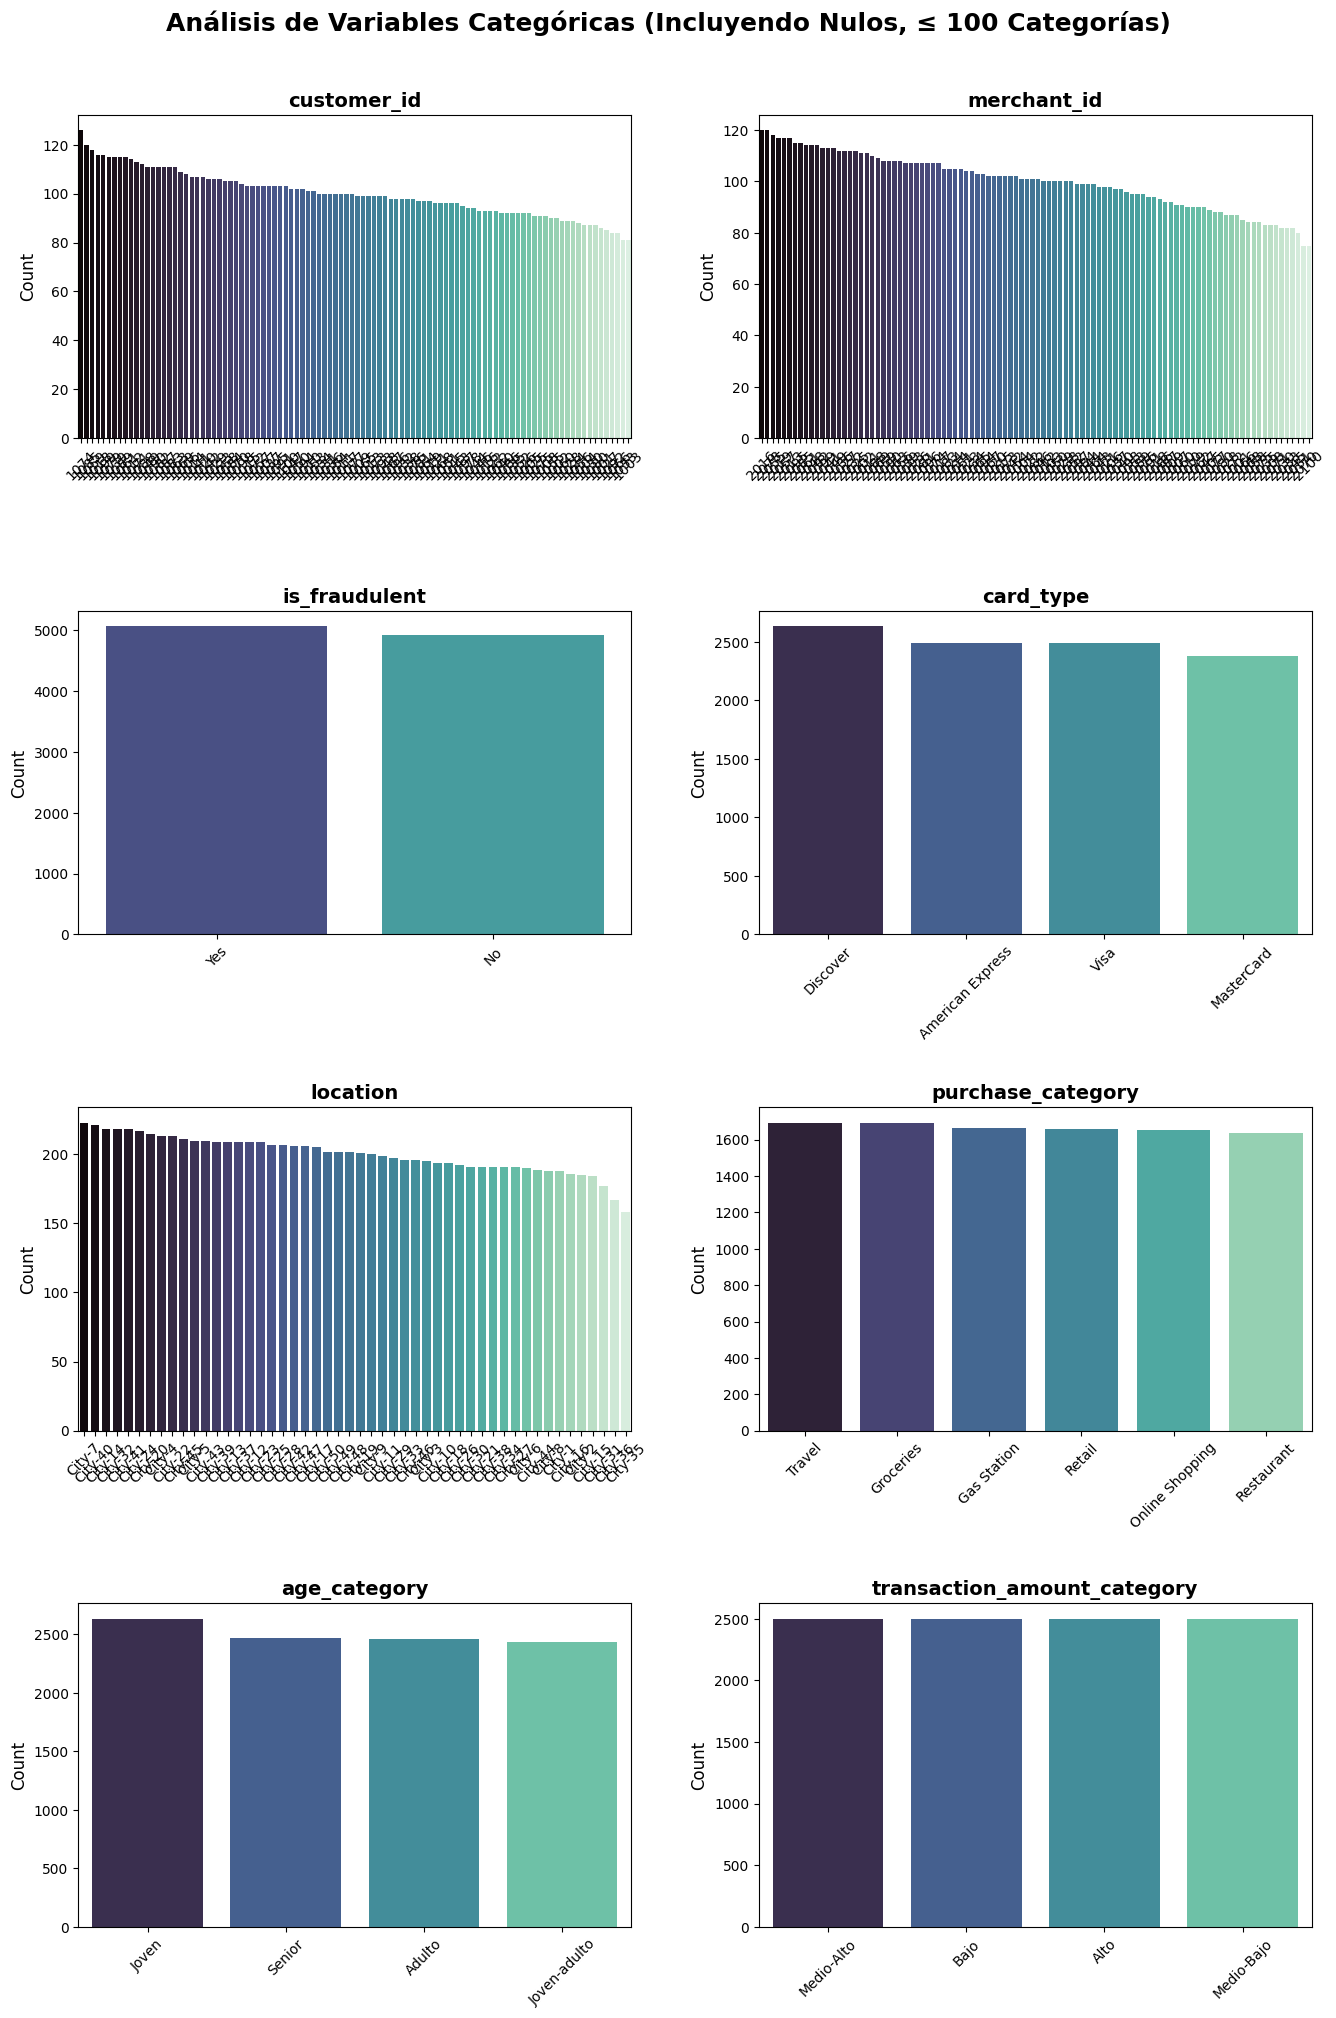

In [454]:
sp.plot_categoricas(df,max_categories=  100)

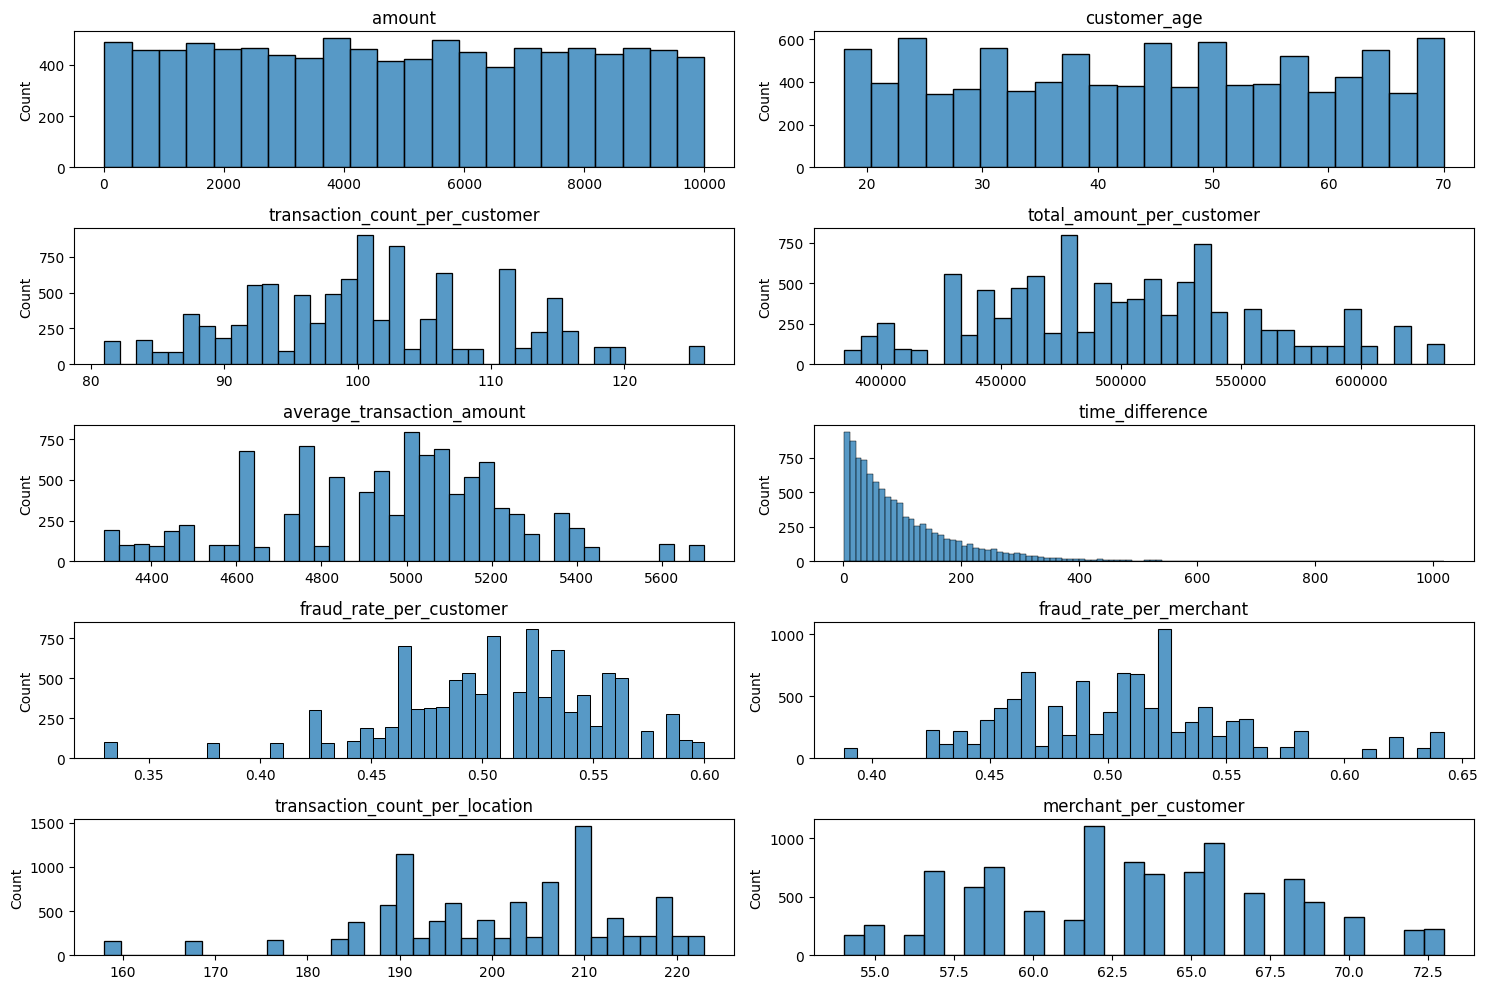

In [455]:
sp.plot_numericas(df)

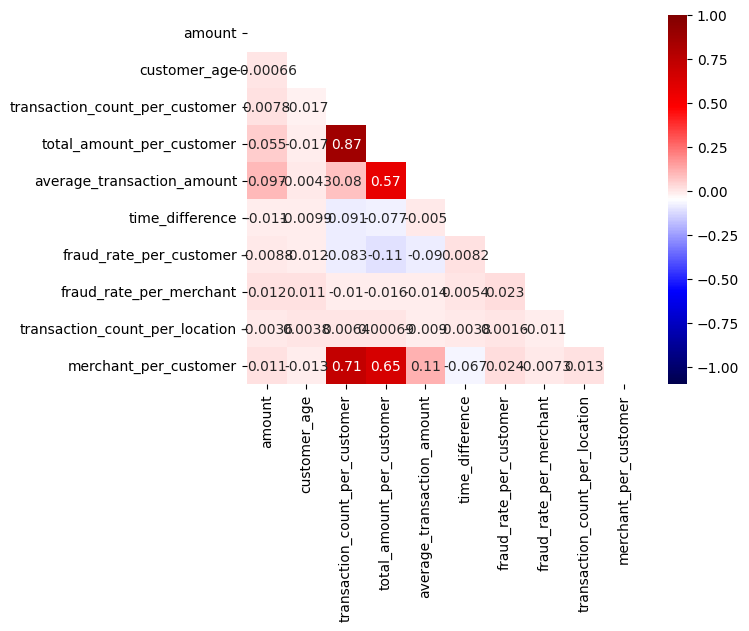

<Figure size 1000x1500 with 0 Axes>

In [456]:
sp.matriz_correlacion(df)

In [457]:
sp.ANOVA(df,"is_fraudulent")

{'amount':                         sum_sq      df         F   PR(>F)
 C(is_fraudulent)  2.234266e+06     1.0  0.265703  0.60624
 Residual          8.407194e+10  9998.0       NaN      NaN,
 'customer_age':                         sum_sq      df         F    PR(>F)
 C(is_fraudulent)  6.815103e+01     1.0  0.290287  0.590049
 Residual          2.347244e+06  9998.0       NaN       NaN,
 'transaction_count_per_customer':                          sum_sq      df         F    PR(>F)
 C(is_fraudulent)      52.170631     1.0  0.600493  0.438408
 Residual          868622.417769  9998.0       NaN       NaN,
 'total_amount_per_customer':                         sum_sq      df         F    PR(>F)
 C(is_fraudulent)  3.570969e+09     1.0  1.125937  0.288669
 Residual          3.170920e+13  9998.0       NaN       NaN,
 'average_transaction_amount':                         sum_sq      df         F    PR(>F)
 C(is_fraudulent)  5.650927e+04     1.0  0.707504  0.400294
 Residual          7.985533e+08  9998

El ANOVA indica que no hay diferencias estadísticamente significativas en las variables amount y customer_age según el factor is_fraudulent. Ambos p-valores son mayores a 0.05, lo que sugiere que ser o no fraudulento no impacta significativamente estas variables.


c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


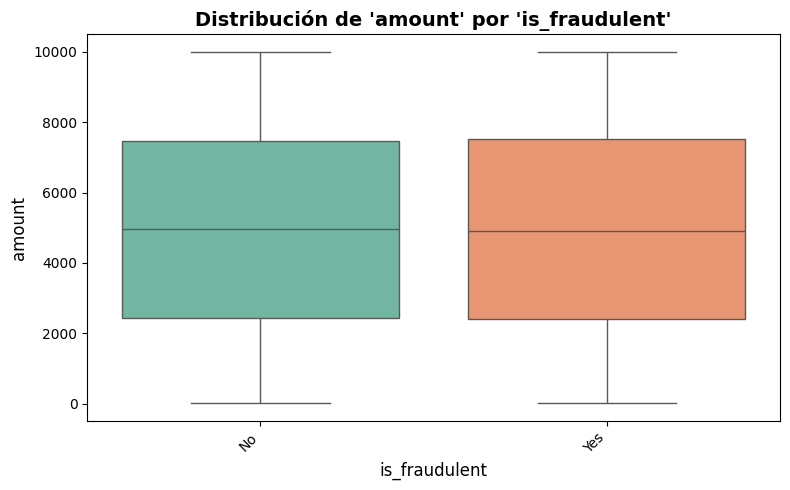

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


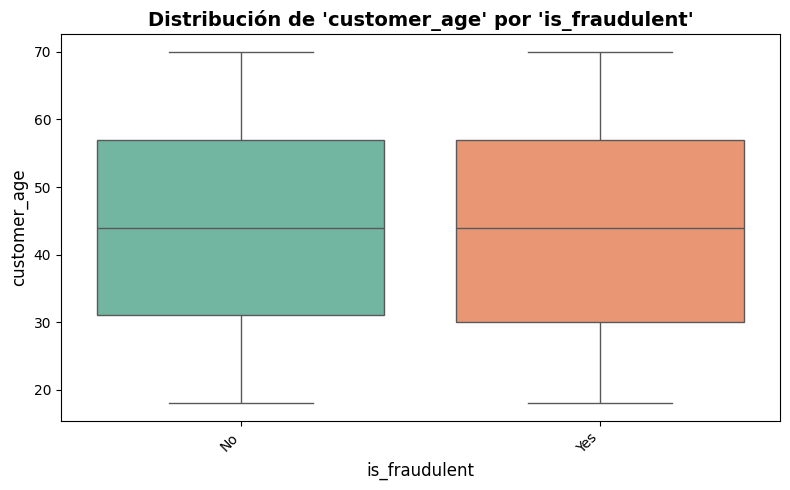

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


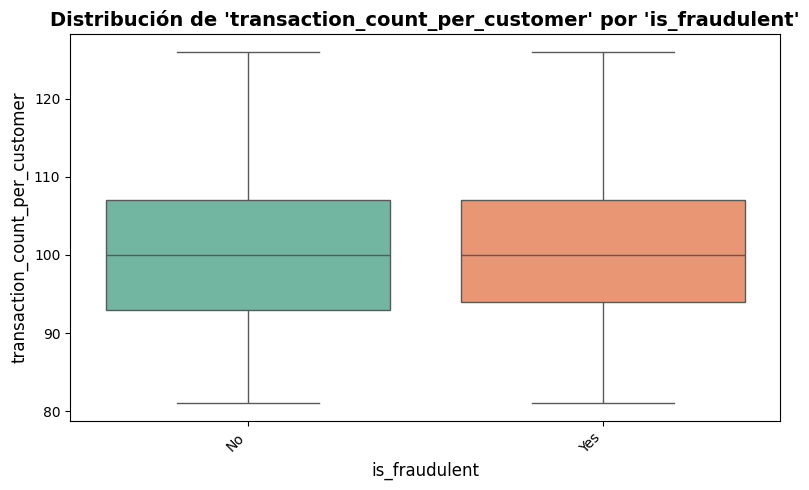

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


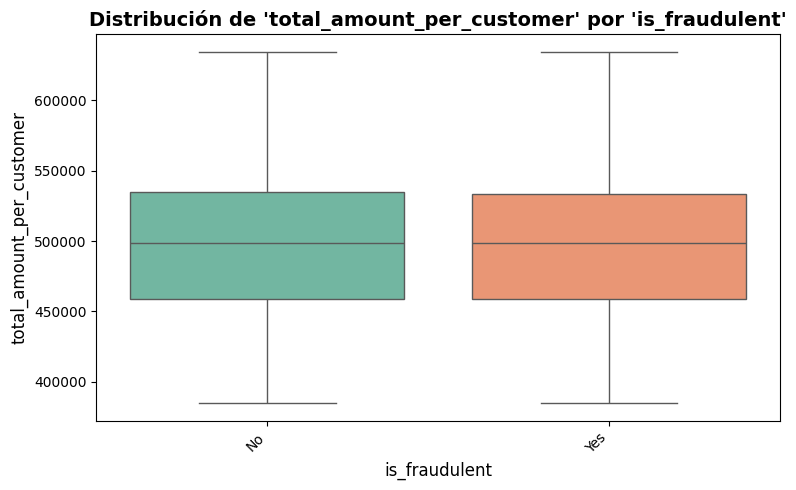

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


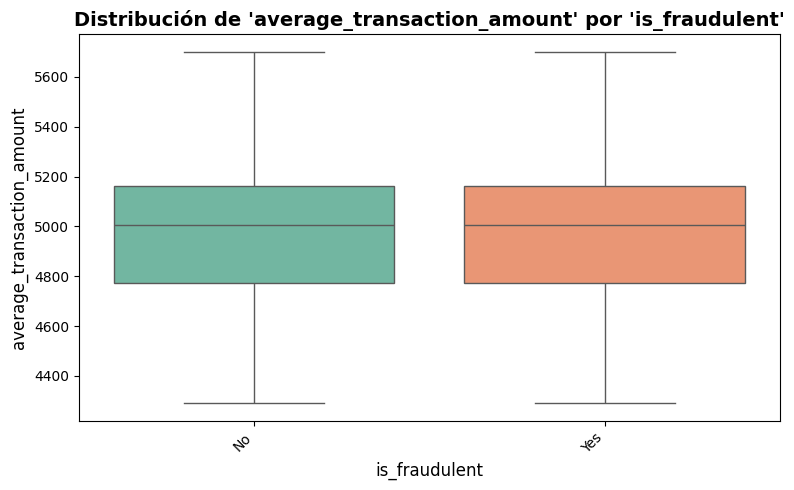

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


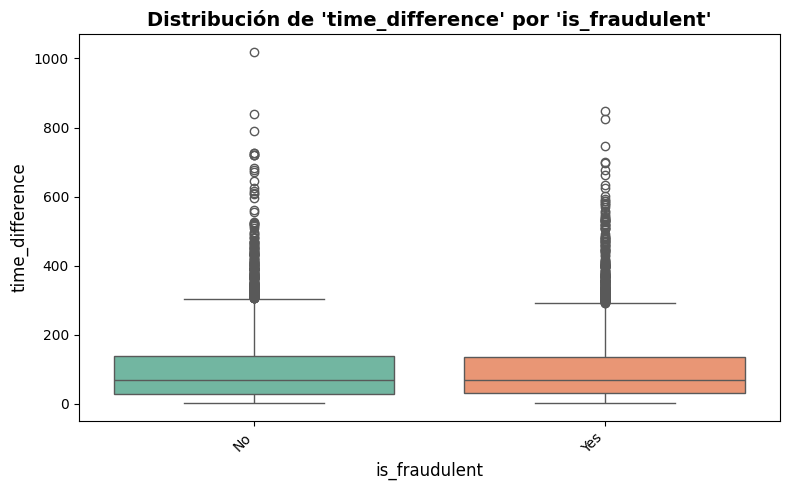

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


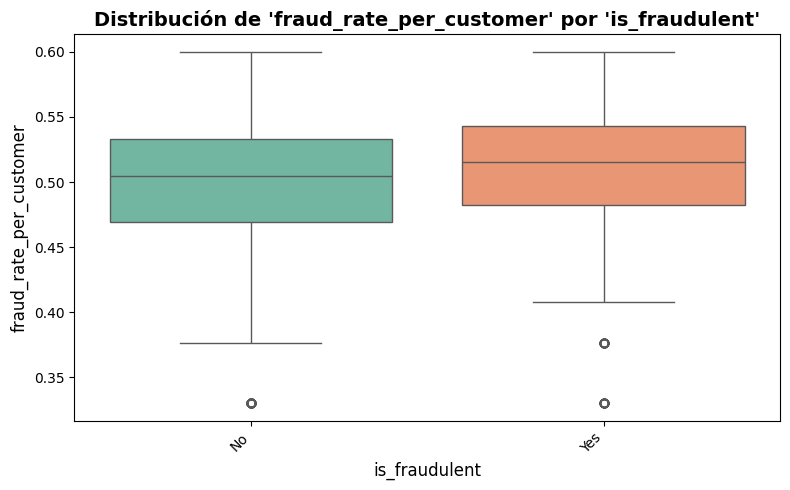

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


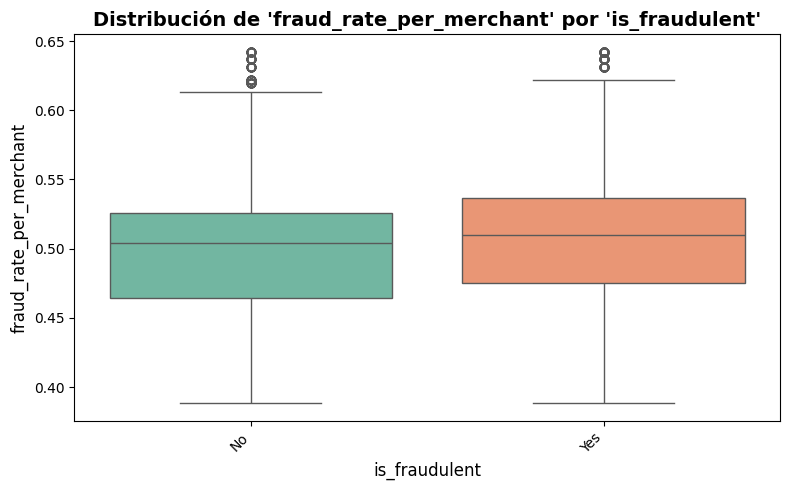

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


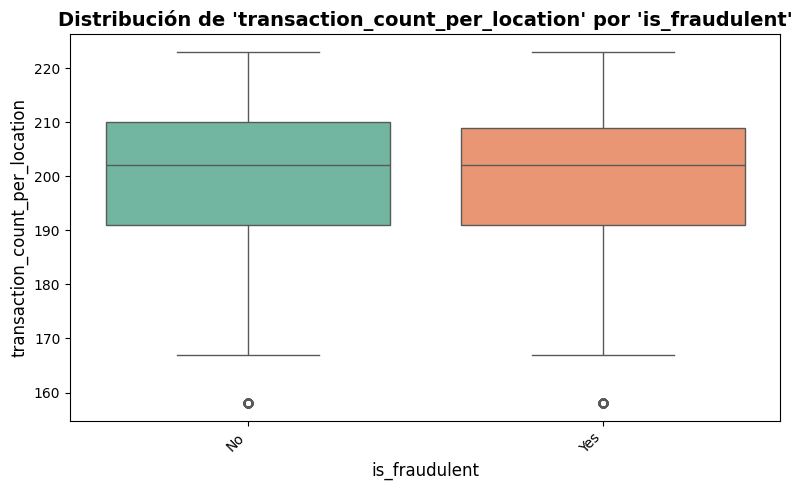

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


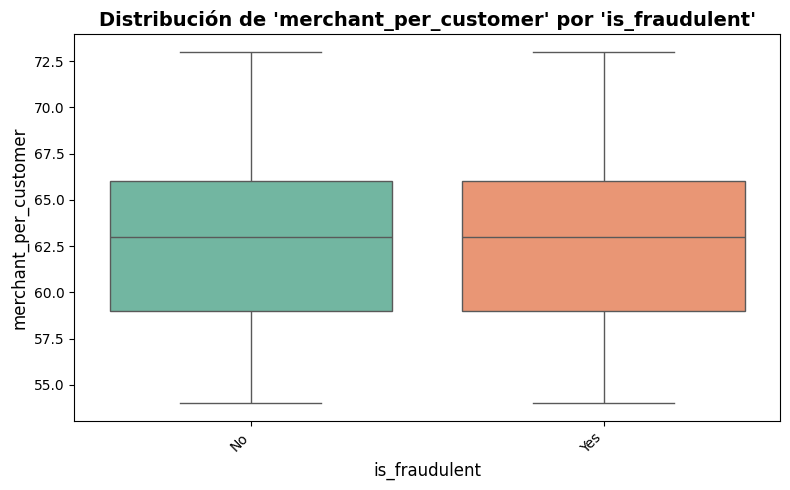

In [458]:
sp.relacion_vr_numericas_boxplot(df, "is_fraudulent")

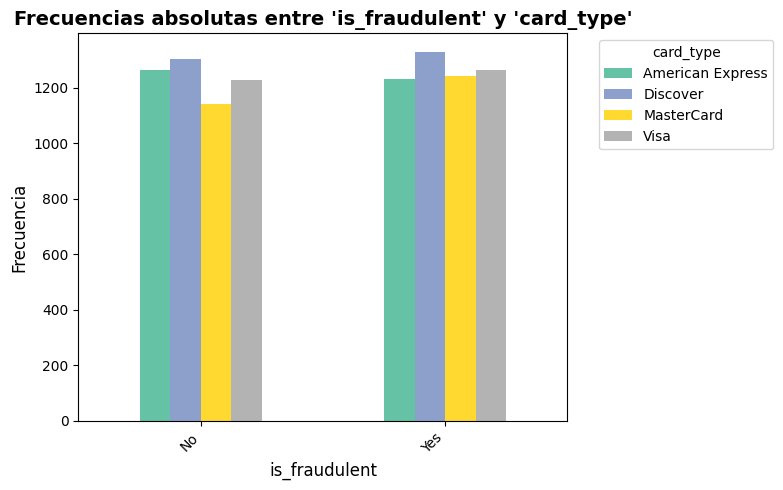

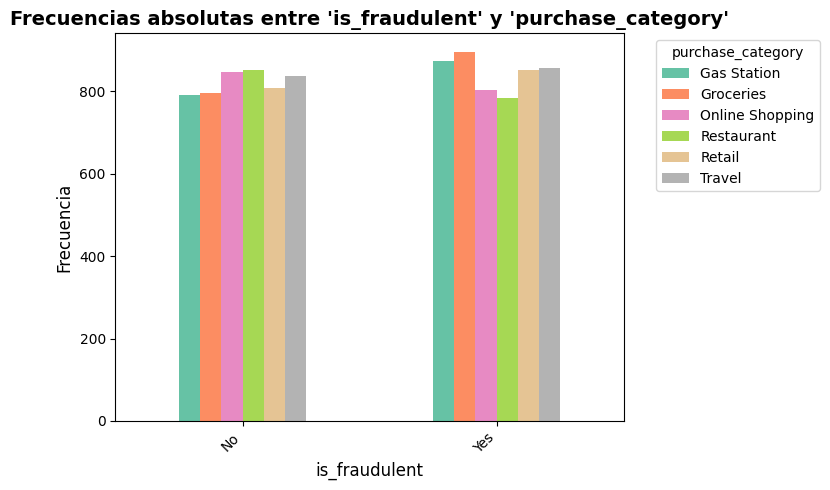

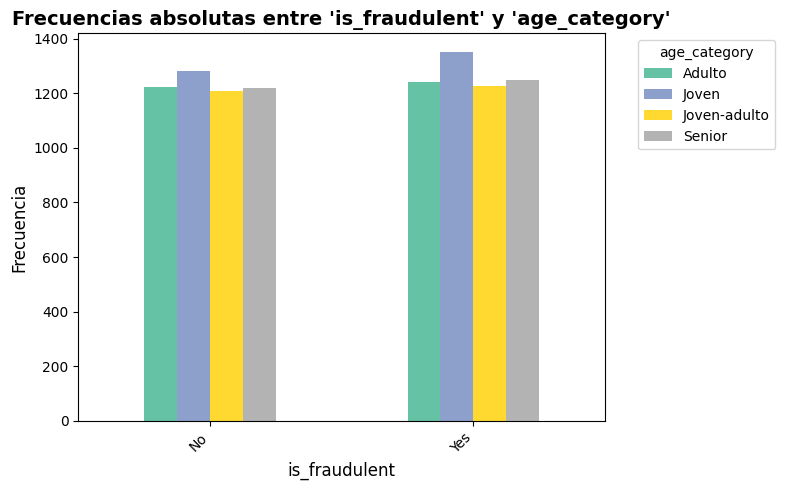

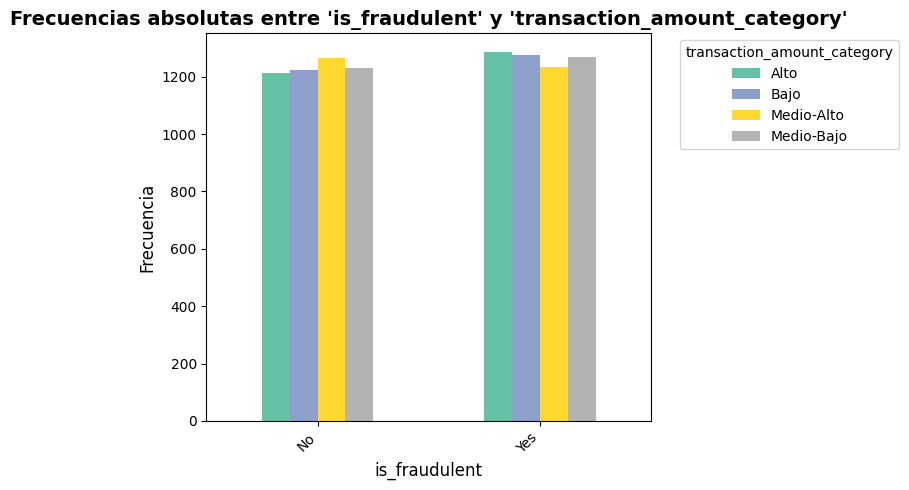

In [459]:
sp.relacion_vr_categoricas_barras_agrupadas(df, "is_fraudulent")

In [460]:
# Vemos la cantidad actual que tenemos de nan
print(df.isnull().sum())

transaction_id                      0
customer_id                         0
merchant_id                         0
amount                              0
transaction_time                    0
is_fraudulent                       0
card_type                           0
location                            0
purchase_category                   0
customer_age                        0
transaction_count_per_customer      0
total_amount_per_customer           0
average_transaction_amount          0
time_difference                   100
age_category                        0
fraud_rate_per_customer             0
fraud_rate_per_merchant             0
transaction_count_per_location      0
transaction_amount_category         0
merchant_per_customer               0
dtype: int64


### Gestion de Outiers

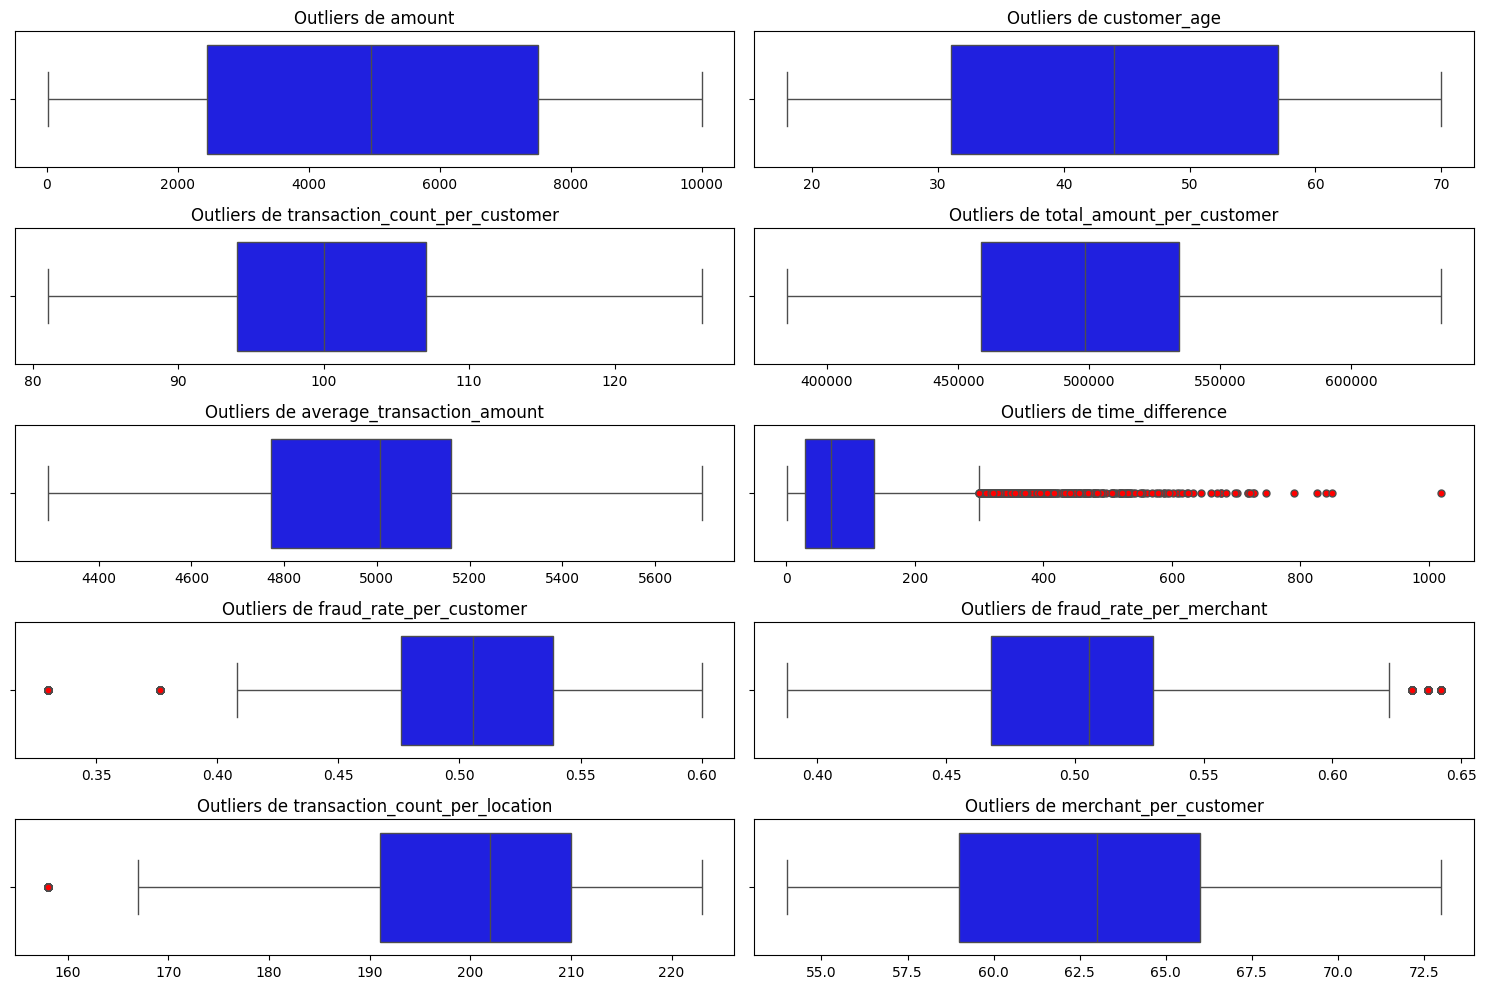

In [461]:
sp.detectar_outliers(df)

In [462]:
col_numericas=["transaction_id","customer_id","merchant_id","customer_age","amount"]
lista_vecinos=[5, 20, 50]
list_contaminacion = [0.01, 0.05, 0.1]

df_lof = df.copy()
df_lof = sp.gestion_nulos_lof(df_lof, col_numericas, lista_vecinos, list_contaminacion)

Aplicando LOF con diferentes parámetros: 100%|██████████| 9/9 [00:00<00:00, 16.52it/s]


In [463]:
df_lof.describe().T

count                           mean  \
amount                          10000.0                    4958.381617   
transaction_time                  10000  2023-01-01 01:23:19.500000256   
customer_age                    10000.0                        44.0475   
transaction_count_per_customer  10000.0                       100.8546   
total_amount_per_customer       10000.0                  500286.867723   
average_transaction_amount      10000.0                    4958.381617   
time_difference                  9900.0                      98.945354   
fraud_rate_per_customer         10000.0                         0.5068   
fraud_rate_per_merchant         10000.0                         0.5068   
transaction_count_per_location  10000.0                       200.8904   
merchant_per_customer           10000.0                        63.1657   
outliers_lof_5_0.01             10000.0                           0.98   
outliers_lof_5_0.05             10000.0                            0.9   
outliers_lof_5_0.1              10000.0                            0.8   
outliers_lof_20_0.01            10000.0                           0.98   
outliers_lof_20_0.05            10000.0                            0.9   
outliers_lof_20_0.1             10000.0                            0.8   
outliers_lof_50_0.01            10000.0                           0.98   
outliers_lof_50_0.05            10000.0                            0.9   
outliers_lof_50_0.1             10000.0                            0.8   

                                                min  \
amount                                        10.61   
transaction_time                2023-01-01 00:00:00   
customer_age                                   18.0   
transaction_count_per_customer                 81.0   
total_amount_per_customer                 384720.36   
average_transaction_amount              4289.675347   
time_difference                                 1.0   
fraud_rate_per_customer                        0.33   
fraud_rate_per_merchant                    0.388235   
transaction_count_per_location                158.0   
merchant_per_customer                          54.0   
outliers_lof_5_0.01                            -1.0   
outliers_lof_5_0.05                            -1.0   
outliers_lof_5_0.1                             -1.0   
outliers_lof_20_0.01                           -1.0   
outliers_lof_20_0.05                           -1.0   
outliers_lof_20_0.1                            -1.0   
outliers_lof_50_0.01                           -1.0   
outliers_lof_50_0.05                           -1.0   
outliers_lof_50_0.1                            -1.0   

                                                          25%  \
amount                                               2438.175   
transaction_time                2023-01-01 00:41:39.750000128   
customer_age                                             31.0   
transaction_count_per_customer                           94.0   
total_amount_per_customer                           458886.13   
average_transaction_amount                        4771.150862   
time_difference                                          29.0   
fraud_rate_per_customer                              0.475728   
fraud_rate_per_merchant                               0.46729   
transaction_count_per_location                          191.0   
merchant_per_customer                                    59.0   
outliers_lof_5_0.01                                       1.0   
outliers_lof_5_0.05                                       1.0   
outliers_lof_5_0.1                                        1.0   
outliers_lof_20_0.01                                      1.0   
outliers_lof_20_0.05                                      1.0   
outliers_lof_20_0.1                                       1.0   
outliers_lof_50_0.01                                      1.0   
outliers_lof_50_0.05                                      1.0   
outliers_lof_50_0.1    

In [464]:
combinaciones_variables = list(combinations(["customer_age","amount"], 2))
columnas_hue = df_lof.filter(like="outlier").columns


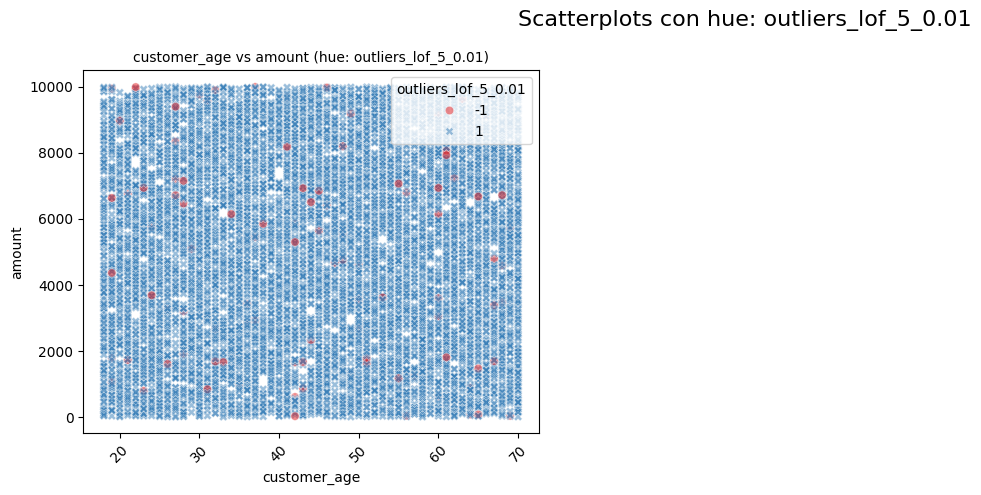

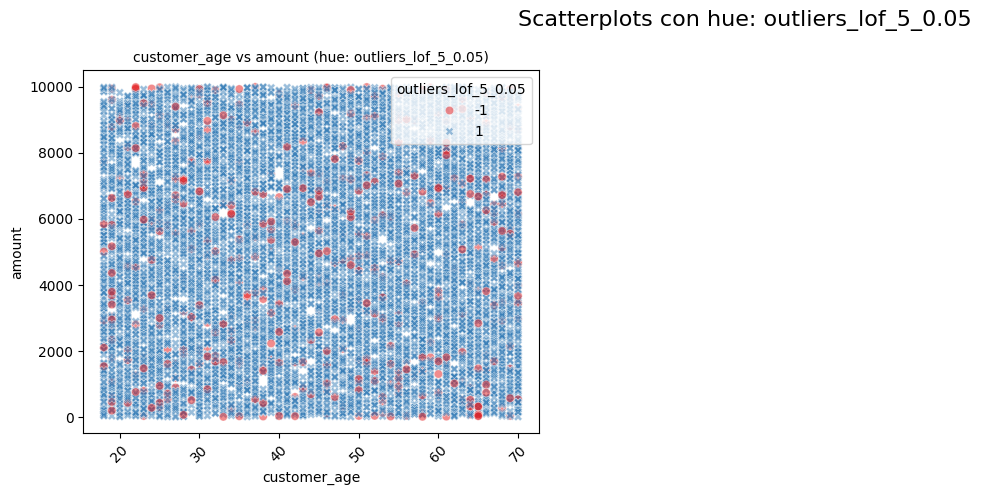

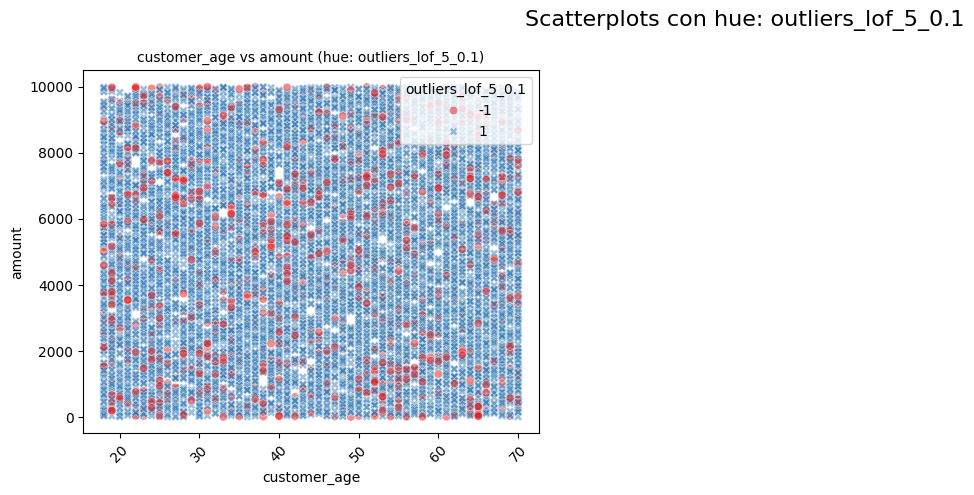

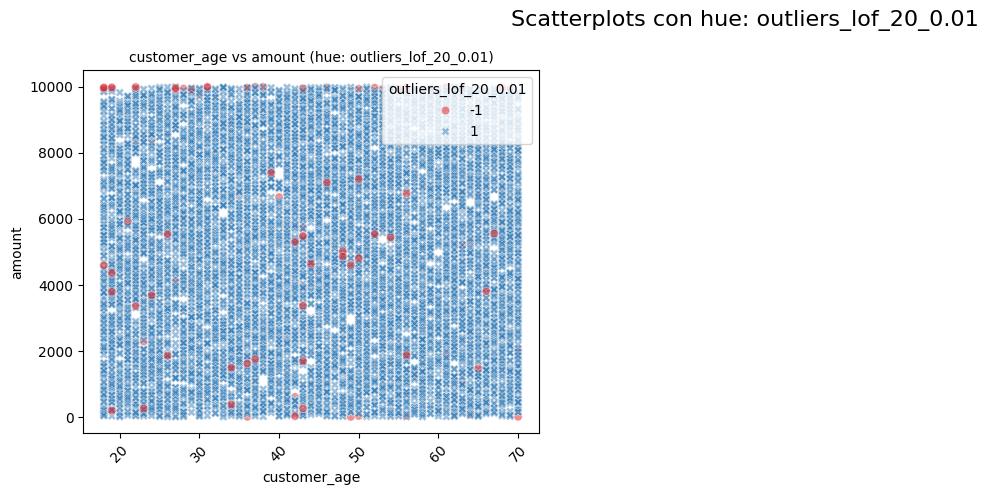

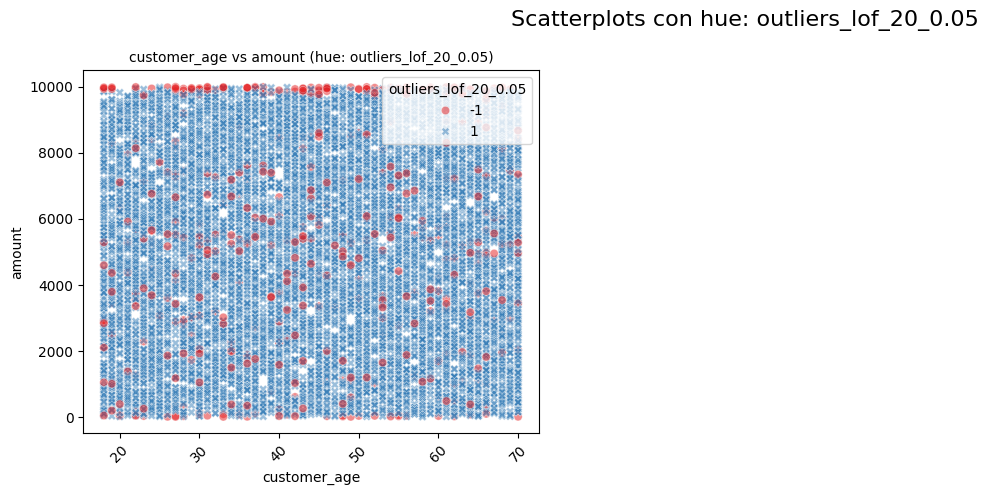

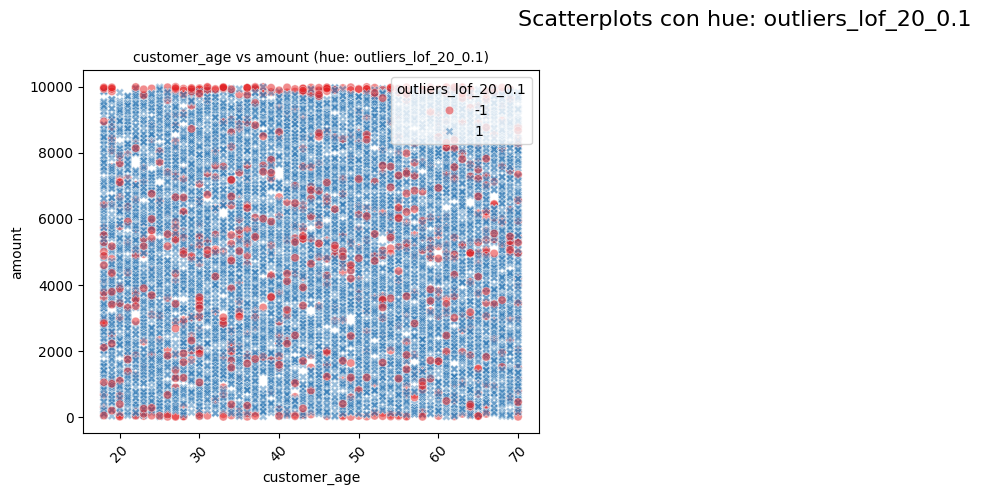

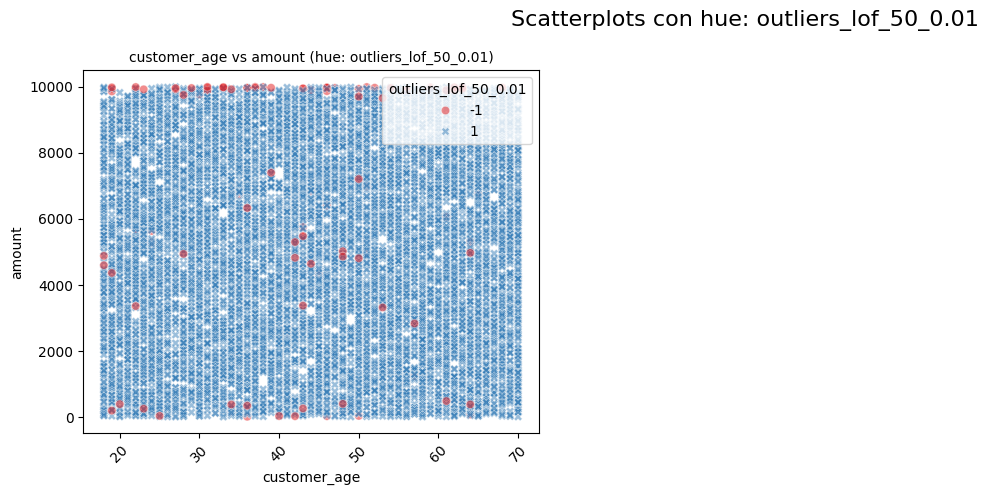

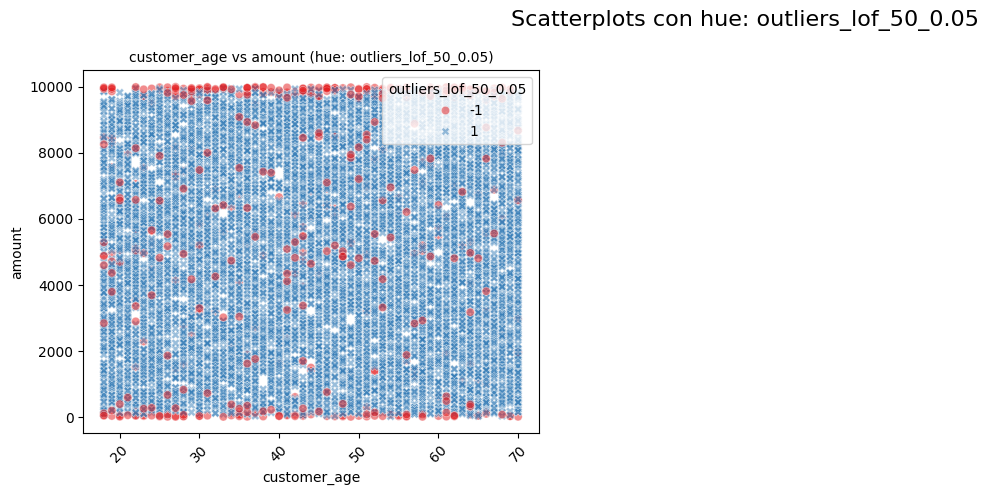

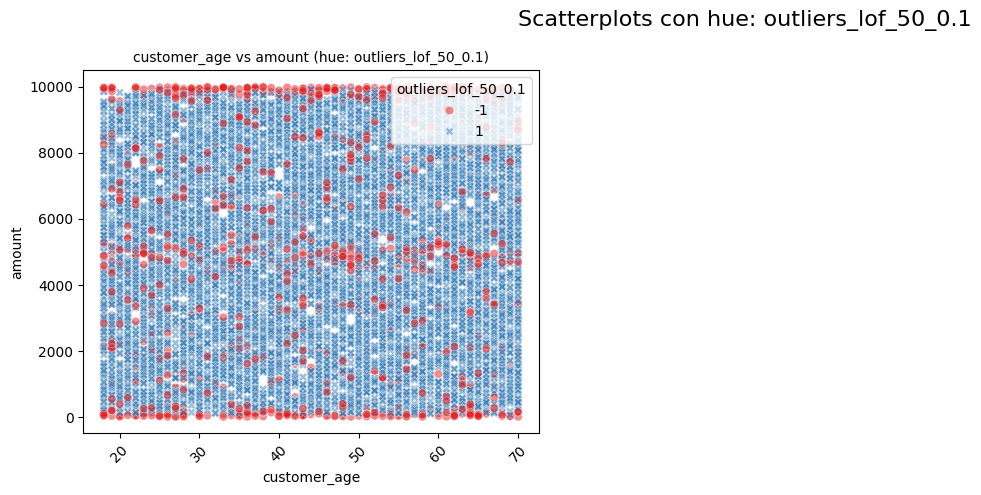

In [465]:
sp.scatterplot_outliers(df_lof,combinaciones_variables,columnas_hue)

In [466]:
cantidad = 7
df_filtrado = df_lof[(df_lof == -1).sum(axis=1) > cantidad]
df_filtrado.shape

(20, 29)

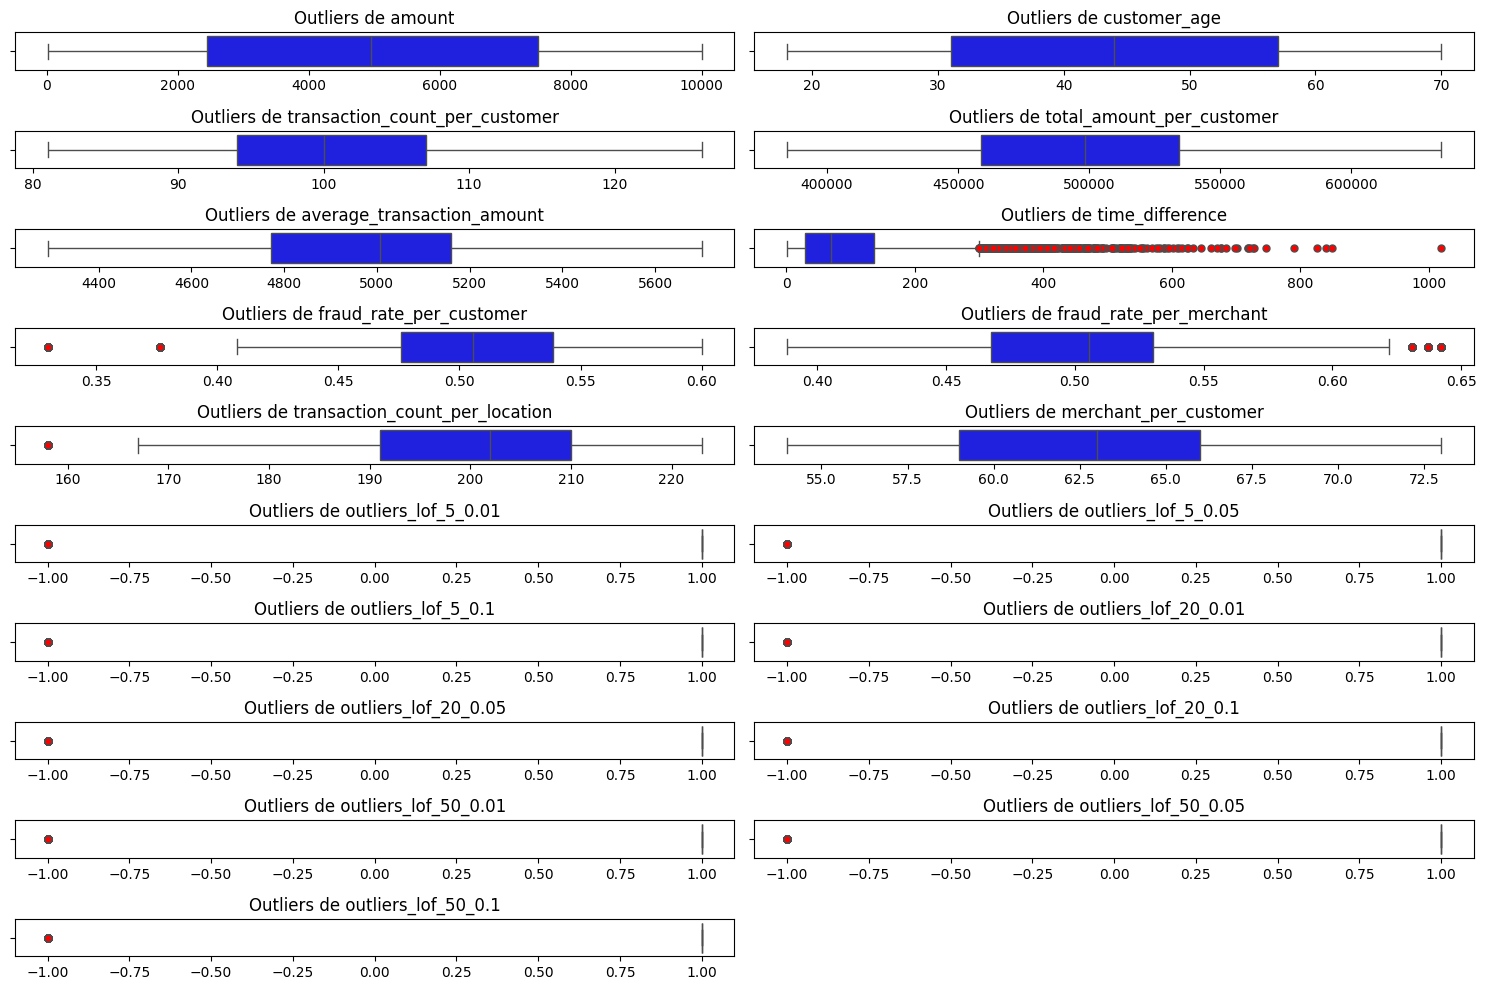

In [467]:
sp.detectar_outliers(df_lof)

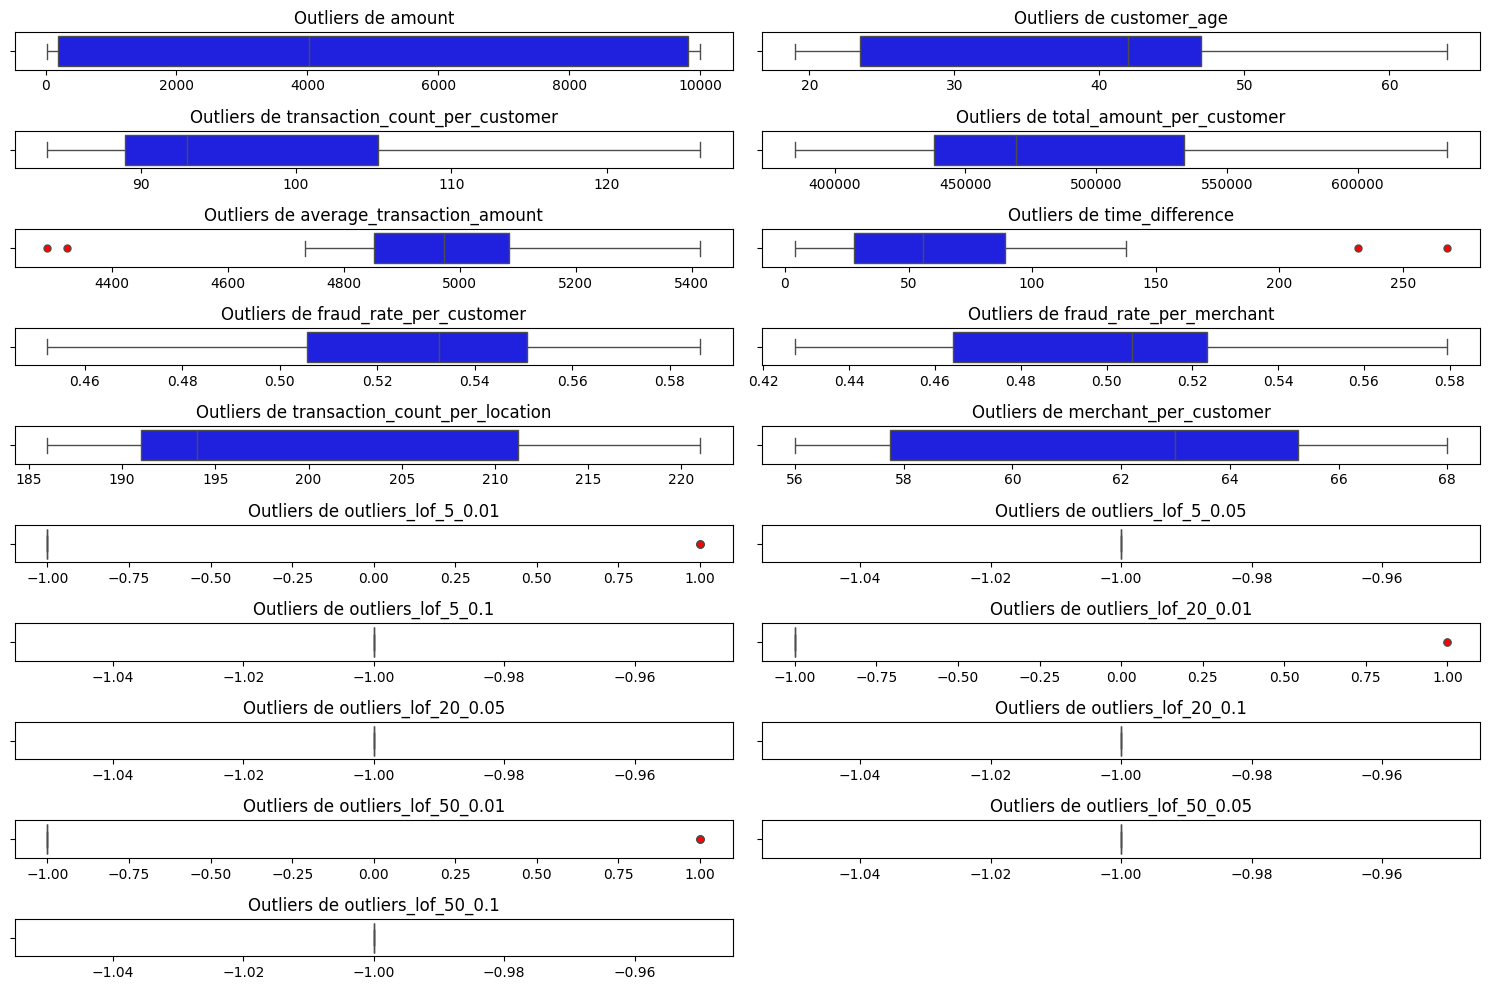

In [468]:
sp.detectar_outliers(df_filtrado)

In [469]:
df_filtrado.describe().T

count                        mean  \
amount                          20.0                   4395.1685   
transaction_time                  20  2023-01-01 00:56:32.300000   
customer_age                    20.0                        38.7   
transaction_count_per_customer  20.0                       98.05   
total_amount_per_customer       20.0                  484791.774   
average_transaction_amount      20.0                 4938.570256   
time_difference                 16.0                      78.125   
fraud_rate_per_customer         20.0                    0.533001   
fraud_rate_per_merchant         20.0                    0.495984   
transaction_count_per_location  20.0                       200.7   
merchant_per_customer           20.0                       61.85   
outliers_lof_5_0.01             20.0                        -0.6   
outliers_lof_5_0.05             20.0                        -1.0   
outliers_lof_5_0.1              20.0                        -1.0   
outliers_lof_20_0.01            20.0                        -0.8   
outliers_lof_20_0.05            20.0                        -1.0   
outliers_lof_20_0.1             20.0                        -1.0   
outliers_lof_50_0.01            20.0                        -0.6   
outliers_lof_50_0.05            20.0                        -1.0   
outliers_lof_50_0.1             20.0                        -1.0   

                                                min  \
amount                                        30.15   
transaction_time                2023-01-01 00:00:02   
customer_age                                   19.0   
transaction_count_per_customer                 84.0   
total_amount_per_customer                 384720.36   
average_transaction_amount              4289.675347   
time_difference                                 4.0   
fraud_rate_per_customer                    0.452381   
fraud_rate_per_merchant                     0.42735   
transaction_count_per_location                186.0   
merchant_per_customer                          56.0   
outliers_lof_5_0.01                            -1.0   
outliers_lof_5_0.05                            -1.0   
outliers_lof_5_0.1                             -1.0   
outliers_lof_20_0.01                           -1.0   
outliers_lof_20_0.05                           -1.0   
outliers_lof_20_0.1                            -1.0   
outliers_lof_50_0.01                           -1.0   
outliers_lof_50_0.05                           -1.0   
outliers_lof_50_0.1                            -1.0   

                                                       25%  \
amount                                            194.0325   
transaction_time                2023-01-01 00:00:29.500000   
customer_age                                          23.5   
transaction_count_per_customer                        89.0   
total_amount_per_customer                        438010.19   
average_transaction_amount                       4851.6399   
time_difference                                       28.0   
fraud_rate_per_customer                           0.505618   
fraud_rate_per_merchant                           0.464194   
transaction_count_per_location                       191.0   
merchant_per_customer                                57.75   
outliers_lof_5_0.01                                   -1.0   
outliers_lof_5_0.05                                   -1.0   
outliers_lof_5_0.1                                    -1.0   
outliers_lof_20_0.01                                  -1.0   
outliers_lof_20_0.05                                  -1.0   
outliers_lof_20_0.1                                   -1.0   
outliers_lof_50_0.01                                  -1.0   
outliers_lof_50_0.05                                  -1.0   
outliers_lof_50_0.1                                   -1.0   

                                                50%                  75%  \
amount                                      4029.19            9811

In [470]:
df_lof.describe().T

count                           mean  \
amount                          10000.0                    4958.381617   
transaction_time                  10000  2023-01-01 01:23:19.500000256   
customer_age                    10000.0                        44.0475   
transaction_count_per_customer  10000.0                       100.8546   
total_amount_per_customer       10000.0                  500286.867723   
average_transaction_amount      10000.0                    4958.381617   
time_difference                  9900.0                      98.945354   
fraud_rate_per_customer         10000.0                         0.5068   
fraud_rate_per_merchant         10000.0                         0.5068   
transaction_count_per_location  10000.0                       200.8904   
merchant_per_customer           10000.0                        63.1657   
outliers_lof_5_0.01             10000.0                           0.98   
outliers_lof_5_0.05             10000.0                            0.9   
outliers_lof_5_0.1              10000.0                            0.8   
outliers_lof_20_0.01            10000.0                           0.98   
outliers_lof_20_0.05            10000.0                            0.9   
outliers_lof_20_0.1             10000.0                            0.8   
outliers_lof_50_0.01            10000.0                           0.98   
outliers_lof_50_0.05            10000.0                            0.9   
outliers_lof_50_0.1             10000.0                            0.8   

                                                min  \
amount                                        10.61   
transaction_time                2023-01-01 00:00:00   
customer_age                                   18.0   
transaction_count_per_customer                 81.0   
total_amount_per_customer                 384720.36   
average_transaction_amount              4289.675347   
time_difference                                 1.0   
fraud_rate_per_customer                        0.33   
fraud_rate_per_merchant                    0.388235   
transaction_count_per_location                158.0   
merchant_per_customer                          54.0   
outliers_lof_5_0.01                            -1.0   
outliers_lof_5_0.05                            -1.0   
outliers_lof_5_0.1                             -1.0   
outliers_lof_20_0.01                           -1.0   
outliers_lof_20_0.05                           -1.0   
outliers_lof_20_0.1                            -1.0   
outliers_lof_50_0.01                           -1.0   
outliers_lof_50_0.05                           -1.0   
outliers_lof_50_0.1                            -1.0   

                                                          25%  \
amount                                               2438.175   
transaction_time                2023-01-01 00:41:39.750000128   
customer_age                                             31.0   
transaction_count_per_customer                           94.0   
total_amount_per_customer                           458886.13   
average_transaction_amount                        4771.150862   
time_difference                                          29.0   
fraud_rate_per_customer                              0.475728   
fraud_rate_per_merchant                               0.46729   
transaction_count_per_location                          191.0   
merchant_per_customer                                    59.0   
outliers_lof_5_0.01                                       1.0   
outliers_lof_5_0.05                                       1.0   
outliers_lof_5_0.1                                        1.0   
outliers_lof_20_0.01                                      1.0   
outliers_lof_20_0.05                                      1.0   
outliers_lof_20_0.1                                       1.0   
outliers_lof_50_0.01                                      1.0   
outliers_lof_50_0.05                                      1.0   
outliers_lof_50_0.1    

In [471]:
df.shape

(10000, 20)

In [472]:
# Eliminamos los outiers al considerarse pocos y que por esa variable puedan modificar el modelo
df2=df.drop(index = df_filtrado.index).reset_index(drop=True)

In [473]:
df2.shape

(9980, 20)

c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:163: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined_counts = pd.concat([category_counts, null_series])
c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
c:\Users\alexc\Desktop\GIT\9.1.Preprocesamiento_vr_categorica\src\support_preprocesing.py:163: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain 

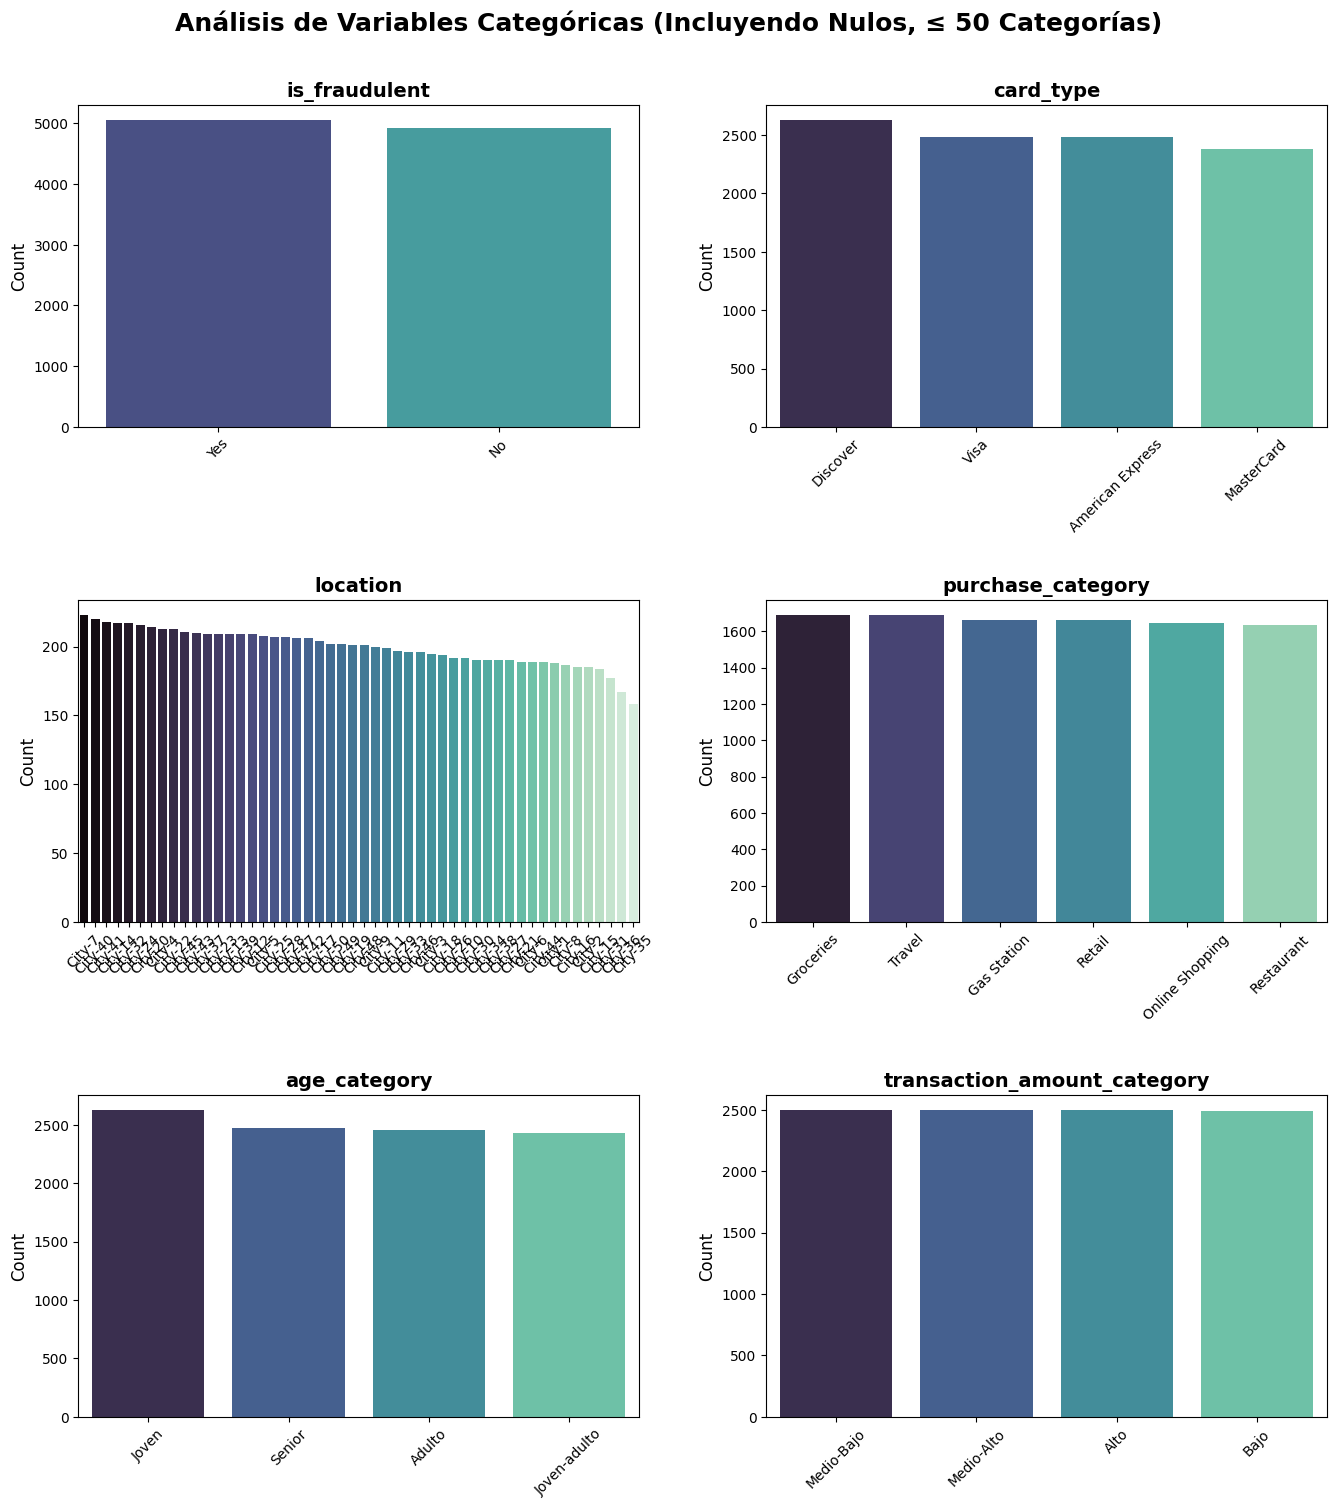

In [474]:
sp.plot_categoricas(df2,max_categories=50)

In [475]:
# Definir df_final 
df_final=df2

In [476]:
# df final para crear modelos
df_final.shape

(9980, 20)

ESTANDARIZACIÓN

In [477]:
# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler

In [478]:
# Selecciona solo las columnas numéricas
numeric_columns = df_final.select_dtypes(include=[np.number]).columns

In [479]:
escalador_robust = RobustScaler()
suffix = "_robust"

# Aplica el escalador a las columnas numéricas
datos_transf_robust = escalador_robust.fit_transform(df_final[numeric_columns])

# Crea un DataFrame con las columnas escaladas y el sufijo
df_scaled_robust = pd.DataFrame(datos_transf_robust, columns=[col + suffix for col in numeric_columns], index=df_final.index)

# Añade las nuevas columnas escaladas al DataFrame original
df1 = pd.concat([df_final, df_scaled_robust], axis=1)

In [480]:
df1.head(1)

transaction_id customer_id merchant_id   amount transaction_time  \
0              1        1082        2027  5758.59       2023-01-01   

  is_fraudulent   card_type location purchase_category  customer_age  \
0            No  MasterCard  City-30       Gas Station            43   

   transaction_count_per_customer  total_amount_per_customer  \
0                             111                  555374.34   

   average_transaction_amount  time_difference  age_category  \
0                 5003.372432              NaN  Joven-adulto   

   fraud_rate_per_customer  fraud_rate_per_merchant  \
0                 0.540541                 0.517857   

   transaction_count_per_location transaction_amount_category  \
0                             191                  Medio-Alto   

   merchant_per_customer  amount_robust  customer_age_robust  \
0                     66       0.160906            -0.038462   

   transaction_count_per_customer_robust  total_amount_per_customer_robust  \
0                               0.846154                          0.755724   

   average_transaction_amount_robust  time_difference_robust  \
0                          -0.008313                     NaN   

   fraud_rate_per_customer_robust  fraud_rate_per_merchant_robust  \
0                        0.556682                        0.197653   

   transaction_count_per_location_robust  merchant_per_customer_robust  
0                              -0.578947                      0.428571

In [481]:
escalador_minmax = MinMaxScaler()
suffix = "_minmax"

# Aplica el escalador a las columnas numéricas
datos_transf_minmax = escalador_minmax.fit_transform(df_final[numeric_columns])

# Crea un DataFrame con las columnas escaladas y el sufijo
df_scaled_minmax = pd.DataFrame(datos_transf_minmax, columns=[col + suffix for col in numeric_columns], index=df_final.index)

# Añade las nuevas columnas escaladas al DataFrame original
df2 = pd.concat([df_final, df_scaled_minmax], axis=1)

In [482]:
df2.head(1)

transaction_id customer_id merchant_id   amount transaction_time  \
0              1        1082        2027  5758.59       2023-01-01   

  is_fraudulent   card_type location purchase_category  customer_age  \
0            No  MasterCard  City-30       Gas Station            43   

   transaction_count_per_customer  total_amount_per_customer  \
0                             111                  555374.34   

   average_transaction_amount  time_difference  age_category  \
0                 5003.372432              NaN  Joven-adulto   

   fraud_rate_per_customer  fraud_rate_per_merchant  \
0                 0.540541                 0.517857   

   transaction_count_per_location transaction_amount_category  \
0                             191                  Medio-Alto   

   merchant_per_customer  amount_minmax  customer_age_minmax  \
0                     66       0.575423             0.480769   

   transaction_count_per_customer_minmax  total_amount_per_customer_minmax  \
0                               0.666667                          0.683631   

   average_transaction_amount_minmax  time_difference_minmax  \
0                           0.505867                     NaN   

   fraud_rate_per_customer_minmax  fraud_rate_per_merchant_minmax  \
0                         0.77978                        0.510389   

   transaction_count_per_location_minmax  merchant_per_customer_minmax  
0                               0.507692                      0.631579

In [483]:
escalador_norm = Normalizer()
suffix = "_norm"

# Aplica el escalador a las columnas numéricas
datos_transf_norm = escalador_norm.fit_transform(df_final[numeric_columns])

# Crea un DataFrame con las columnas escaladas y el sufijo
df_scaled_norm = pd.DataFrame(datos_transf_norm, columns=[col + suffix for col in numeric_columns], index=df_final.index)

# Añade las nuevas columnas escaladas al DataFrame original
df3 = pd.concat([df_final, df_scaled_norm], axis=1)

ValueError: Input X contains NaN.
Normalizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
df3.head(1)

In [ ]:
escalador_stds = StandardScaler()
suffix = "_stds"

# Aplica el escalador a las columnas numéricas
datos_transfr_stds = escalador_stds.fit_transform(df_final[numeric_columns])

# Crea un DataFrame con las columnas escaladas y el sufijo
df_scaled_stds = pd.DataFrame(datos_transfr_stds, columns=[col + suffix for col in numeric_columns], index=df_final.index)

# Añade las nuevas columnas escaladas al DataFrame original
df4 = pd.concat([df_final, df_scaled_stds], axis=1)

In [ ]:
df4.head(1)

In [ ]:
df_list=[df1,df2,df3,df4]

In [ ]:
sp.generador_boxplots(df_list)

Una vez realizado la estandarizacion se opta por utilizar el metodo "Robust" para dar peso a los pocos outiers que hemos podido dejar en la muestra y que se tengan en cuenta en el modelo

In [ ]:
df_final.head()

In [ ]:
df_estandarizado = pd.concat([df_final, df_scaled_robust], axis=1)
df_estandarizado=df_estandarizado.drop(columns=["amount","customer_age"])

In [ ]:
df_estandarizado.sample(10)

Ahora procedemos con el Encoding de las variables categoricas

In [ ]:
df_estandarizado.dtypes

In [ ]:
lista_col_categ = df_estandarizado.select_dtypes(include="O").columns.tolist()
lista_col_categ

In [ ]:
lista_col_num = df_estandarizado.select_dtypes(include=np.number).columns.tolist()
lista_col_num

In [ ]:
sp.relacion_vr_categoricas_barras_agrupadas(df_estandarizado,"is_fraudulent")

In [ ]:
df_estandarizado.head()

In [ ]:
df_encoded.to_csv('results/df_encoded.csv', index=False)